# Deep Colaborative Filtering using Skorch
This notebook follows the steps required to build and train a neural network for the purpose of collaborative filtering, using the [MovieLens](https://grouplens.org/datasets/movielens/latest/) data set.   

The neural network will be built using the [PyTorch](https://pytorch.org/) framework, with the [Skorch library](https://github.com/dnouri/skorch) being used to make training and testing the model simple.   

<a target="_blank" href="https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/movielens_skorch.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

## Load data

In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data_url = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/movielens-small/ratings.csv'

In [3]:
df = pd.read_csv(data_url).drop('timestamp', axis=1)

In [4]:
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
max_score = max(df.rating)
min_score = min(df.rating)

In [6]:
print("Number of users:", n_users) 
print("Number of movies:", n_items)
print("Ratings range between", min_score, "and", max_score)

Number of users: 610
Number of movies: 9724
Ratings range between 0.5 and 5.0


### Encode IDs from 0-n
The users and movies in the data set all have unique IDs, but the values of these IDs do not all fall in one sequential range from 0 up to the total number of users/movies.   

Since there will be an embedding layer in the neural network, the user and movie IDs need to reset to all fall between 0 and the total number of users and movies respectively.

In [7]:
# sort IDs
movie_ids = np.sort(df.movieId.unique())
user_ids = np.sort(df.userId.unique())

In [8]:
def create_index(data, start=0):
    
    'Create mapping from unordered IDs to sequential IDs, ranging from 0-n'

    encoder = {}
    decoder = {}

    idx = start
    for item in data:

        if item not in encoder.keys():
            encoder[item] = idx
            decoder[idx] = item
            idx += 1

    return encoder, decoder

In [9]:
movie_encoder, movie_decoder = create_index(movie_ids)
user_encoder, user_decoder = create_index(user_ids)

In [10]:
df.movieId = df.movieId.replace(movie_encoder)
df.userId = df.userId.replace(user_encoder)

In [11]:
print("Max user ID:", max(df.userId.unique()))
print("Max movie ID:", max(df.movieId.unique()))

Max user ID: 609
Max movie ID: 9723


There are a total of 610 users, who now each have a unique ID between 0 and 609, and similarly the movies now all have IDs between 0 and 9723.

### Create test set
The next step is to split the data into train and test sets. A ratio of 80:20 will be used in this example.   

First, the data is separated into features (user Ids, movie Ids) and targets (ratings).

In [12]:
X = df.iloc[:,:2].values
y = df.iloc[:,2].values
y = y.astype('float32')

Then, the features and targets are separated into train and test sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X[:,0])

In [14]:
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [15]:
X_train.shape, y_train.shape

((80668, 2), (80668, 1))

## Neural network
The next step is to create the neural network, using the PyTorch framework.   

This neural network will be pretty simple, with the input being simply a user-movie pair, and the output being a predicted rating.
Between the input and the output, we have two layers:   
  - embedding layer (with dropout)
  - hidden layer (with dropout and relu activation function)   
  
![Architecture](https://github.com/James-Leslie/Netflix-Recommender-System/blob/master/diagrams/EmbeddingNet.png?raw=true)   

The architecture shown above is very similar to that of a standard feed-forward neural network, with one significant difference.   

Each User and Movie ID will have a set of embeddings which can be 'learned' through training.   
Only when observations with that particular User or Movie ID are fed through the network, will the network activate (and update) the mapped embeddings.   
In other words, User1 and User2 will have different values for the nodes in the first layer. When passing ratings made my User1 into the network, then only User1's embedding layer will be trained.   
Similarly, when ratings for Movie1 are passed into the network, then only the movie embeddings associated to that movie will be updated through training.   

The hidden layer of the network is fully connected to the embedding layer, and thus will always be updated in any training batch.   

Finally, a scaled sigmoid activation function is used to squeeze the outputs between 0.5 and 5.0.

In [16]:
import torch
from torch import nn
import torch.nn.functional as F

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

In [19]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score, self.max_score = min_score, max_score

        # get user and item embeddings
        (self.u, self.i) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, 10)  # 10 hidden neurons
        self.lin2 = nn.Linear(10, 1)
        self.drop1 = nn.Dropout(0.05)  # dropout rate of 5%
        self.drop2 = nn.Dropout(0.15)  # dropout rate of 15%

    def forward(self, X, **kwargs):
        users, items = X[:,0], X[:,1]
        # concatenate embeddings to form first layer, add dropout
        x = self.drop1(torch.cat([self.u(users),self.i(items)], dim=1))
        # second layer with 10 hidden neurons and dropout
        x = self.drop2(F.relu(self.lin1(x)))
        # output layer with one neuron
        x = self.lin2(x)
        # add sigmoid activation function, but squeeze between min and max score
        return torch.sigmoid(x) * (self.max_score - self.min_score) + self.min_score

### Training using Skorch
The skorch library makes it easy to train the model, in a similar manner to Sk Learn models.

In [20]:
from skorch import NeuralNetRegressor

In [21]:
net = NeuralNetRegressor(
    module=EmbeddingNet,
    module__n_factors=10,
    module__n_users=n_users,
    module__n_items=n_items,
    module__min_score=min_score,
    module__max_score=max_score,
    max_epochs=10,
    lr=0.1,
    device=device,
)

In [23]:
net.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: max_score, min_score, n_factors, n_items, n_users.
Re-initializing optimizer because the following parameters were re-set: .
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0748        1.0195  2.5422
      2        0.9460        0.8650  2.5522
      3        0.8619        0.8350  2.5382
      4        0.8152        0.8087  2.5582
      5        0.7890        0.8017  2.6051
      6        0.7734        0.8067  2.5961
      7        0.7581        0.8111  2.6768
      8        0.7487        0.8098  3.2234
      9        0.7375        0.8026  2.8285
     10        0.7226        0.8018  2.6659


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=EmbeddingNet(
    (u): Embedding(610, 10)
    (i): Embedding(9724, 10)
    (lin1): Linear(in_features=20, out_features=10, bias=True)
    (lin2): Linear(in_features=10, out_features=1, bias=True)
    (drop1): Dropout(p=0.05)
    (drop2): Dropout(p=0.15)
  ),
)

### Test on unseen data
The RMSE score on the test set for this model is 0.886, which is better than the best performance (0.91) achieved by the [Librec System](https://www.librec.net/release/v1.3/example.html) for collaborative filtering.

In [24]:
preds = net.predict(X_test)

In [25]:
import seaborn as sns

C:\Users\jlesl\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


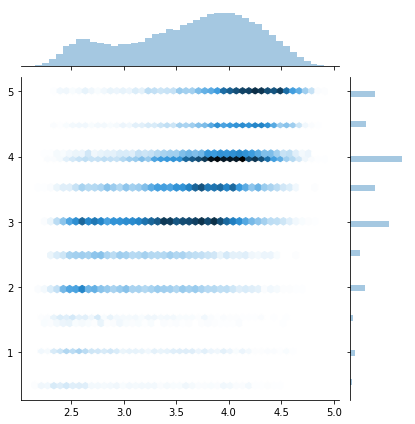

In [26]:
sns.jointplot(preds, y_test, kind='hex', stat_func=None);

In [27]:
np.sqrt(np.mean((preds - y_test) ** 2))

0.882782

# Now, try to train the same model with PyTorch
Use the same `EmbeddingNet` model as before, but now do the training process using plain PyTorch, instead of Skorch.

In [28]:
from torch.utils.data import Dataset, DataLoader
from torch import optim
from tqdm import tqdm_notebook as tqdm

## Load data
First, need to create a `Dataset` class which will be used to send data to the model.

In [29]:
class ExplicitDataset(Dataset):
    """Recommender dataset with explicit ratings"""

    def __init__(self, csv_file, users='user_id', items='item_id', ratings='rating'):
        """
        Args:
        csv_file (string):
            Path to the csv file with user-item interactions

        users (string):
            column name from long_df for user IDs

        items (string):
            column name from long_df for item IDs

        ratings (string):
            column name from long_df for ratings
        """

        self.df = pd.read_csv(csv_file)

        # get column numbers
        self.user_loc = self.df.columns.get_loc(users)
        self.item_loc = self.df.columns.get_loc(items)
        self.rating_loc = self.df.columns.get_loc(ratings)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        inputs = torch.tensor(self.df.iloc[idx, :-1].values.astype('int64'))
        rating = torch.tensor(self.df.iloc[idx, self.rating_loc])

        return (inputs, rating)

### "Here's one I made earlier"
I have two files which I saved earlier as CSVs. I made sure to keep the user and item IDs in the correct format (0-n as above).

In [30]:
train_url = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/movielens-small/train.csv'
test_url = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/movielens-small/test.csv'

Quick confirmation that the data is still intact:

In [31]:
train = ExplicitDataset(csv_file=train_url, users='userId', items='movieId')
test = ExplicitDataset(csv_file=test_url, users='userId', items='movieId')

In [32]:
train.df.head()

,userId,movieId,rating
0,463,2247,2.5
1,306,1616,2.5
2,605,98,3.5
3,306,2437,3.0
4,408,2030,4.0


In [33]:
test.df.head()

,userId,movieId,rating
0,160,6208,0.5
1,134,857,4.0
2,522,8627,5.0
3,367,1118,3.0
4,57,200,4.0


In [34]:
n_users = max(max(train.df.userId.unique()), max(test.df.userId.unique()))
n_items = max(max(train.df.movieId.unique()), max(test.df.movieId.unique()))
max_score = max(train.df.rating)
min_score = min(train.df.rating)
epoch = 10
bs = 128

In [35]:
print("Number of users:", n_users+1) 
print("Number of movies:", n_items+1)
print("Ratings range between", min_score, "and", max_score)

Number of users: 610
Number of movies: 9724
Ratings range between 0.5 and 5.0


## DataLoader
Now, use the `DataLoader` function to iterate over the data in batches.

In [36]:
train_loader = DataLoader(dataset=train,
                          batch_size=bs,
                          shuffle=False)

test_loader = DataLoader(dataset=test,
                         batch_size=bs,
                         shuffle=False)

In [37]:
dataiter = iter(train_loader)

In [38]:
inputs, ratings = dataiter.next()

In [39]:
# send tensors to GPU
inputs, ratings = inputs.cuda(), ratings.cuda()

In [40]:
inputs.shape, ratings.shape

(torch.Size([128, 2]), torch.Size([128]))

### Pass data to model
Take a look at the data by uncommenting the block below.

In [41]:
# inputs
# ratings

Then, test that the model is able to feed this data from input to output.

In [42]:
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

In [43]:
model.eval()
with torch.no_grad():
    output = model(inputs).view(bs).cpu().numpy()

In [44]:
output

array([2.586892 , 2.5870132, 2.5858014, 2.5871866, 2.5872777, 2.5876944,
       2.5862515, 2.5861318, 2.5889258, 2.5876186, 2.5860791, 2.5881646,
       2.5876532, 2.5863268, 2.586345 , 2.587614 , 2.5873096, 2.588437 ,
       2.585979 , 2.58817  , 2.586538 , 2.5888486, 2.5881858, 2.5878677,
       2.589509 , 2.5867217, 2.5880096, 2.5869071, 2.5882583, 2.587781 ,
       2.5894928, 2.588545 , 2.5886035, 2.588476 , 2.5887237, 2.586669 ,
       2.5865006, 2.5864987, 2.5864809, 2.5882833, 2.5885901, 2.5883052,
       2.5885744, 2.5900066, 2.5889997, 2.586958 , 2.588749 , 2.5874677,
       2.587732 , 2.5880244, 2.5878854, 2.5873373, 2.5864296, 2.5874317,
       2.5877728, 2.5879035, 2.5863378, 2.5885088, 2.5862648, 2.5883453,
       2.5885222, 2.5867636, 2.5862923, 2.5880096, 2.5841932, 2.589489 ,
       2.587674 , 2.586599 , 2.5875201, 2.5897288, 2.5866935, 2.5872383,
       2.5881991, 2.5873485, 2.5899634, 2.5868344, 2.5866373, 2.5874705,
       2.5893579, 2.5873237, 2.5873964, 2.5878181, 

In [45]:
ratings = ratings.cpu().numpy()

In [46]:
rmse = np.sqrt(np.mean((ratings - output)**2))

In [47]:
rmse

1.3887048

## Train model
Now, the data is in a format that can be passed to the model. Next step is to run a few epochs using the standard format of the PyTorch training loop.

In [48]:
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [51]:
train_losses, test_losses = [], []
for e in range(epochs):

    # training loop
    model.train()
    running_loss = 0.0

    for inputs, rating in tqdm(train_loader):
        inputs, rating = inputs.cuda(), rating.cuda()

        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, rating)

        # update weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # validation at end of epoch
    else:
        # print training loss
        print("Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)))
        running_loss = 0.0

        # calculate test loss
        test_loss = 0.0

        # turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # turn off dropout
            model.eval()
            for inputs, rating in test_loader:
                inputs, rating = inputs.cuda(), rating.cuda()
                output = model(inputs)
                test_loss += criterion(output, rating)

        # print test loss
        print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Epoch: {}/{}.. ".format(e+1, epochs))


Training Loss: 1.106.. 
Test Loss: 1.074..  Epoch: 1/5.. 



Training Loss: 1.089.. 
Test Loss: 1.074..  Epoch: 2/5.. 



Training Loss: 1.089.. 
Test Loss: 1.074..  Epoch: 3/5.. 



Training Loss: 1.088.. 
Test Loss: 1.074..  Epoch: 4/5.. 



Training Loss: 1.088.. 
Test Loss: 1.074..  Epoch: 5/5.. 


## Make predictions

In [52]:
inputs, ratings = dataiter.next()
inputs, ratings = inputs.cuda(), ratings.cuda()

In [53]:
model.eval()
with torch.no_grad():
    output = model(inputs).view(bs).cpu().numpy()

In [54]:
output

array([3.4936843, 3.4936843, 3.5033796, 3.535034 , 3.4936843, 3.52073  ,
       3.512241 , 3.5010383, 3.4889705, 3.4936843, 3.4936843, 3.4947264,
       3.4969945, 3.4936843, 3.4936843, 3.5214617, 3.5286322, 3.538677 ,
       3.5199542, 3.5516493, 3.5109003, 3.504245 , 3.5229595, 3.5106912,
       3.5656173, 3.4936843, 3.4936843, 3.495426 , 3.5062435, 3.4936843,
       3.4936843, 3.4941254, 3.512733 , 3.4962459, 3.5051613, 3.5231278,
       3.4936843, 3.5436897, 3.513577 , 3.4936843, 3.4978585, 3.4936843,
       3.4963915, 3.4936843, 3.4958165, 3.5651534, 3.4936843, 3.4983602,
       3.4936843, 3.5145533, 3.4936843, 3.4936843, 3.4936843, 3.4936843,
       3.4936843, 3.5181456, 3.5489833, 3.4936843, 3.5426373, 3.5130644,
       3.4936843, 3.4936843, 3.4936843, 3.4936843, 3.5121572, 3.4936843,
       3.4936843, 3.4941695, 3.4936843, 3.5050144, 3.4936843, 3.5126834,
       3.4942536, 3.498128 , 3.4936843, 3.5367868, 3.4936843, 3.4936843,
       3.5210981, 3.5361323, 3.5058079, 3.4936843, 

In [55]:
ratings = ratings.cpu().numpy()

In [56]:
rmse = np.sqrt(np.mean((ratings - output)**2))

In [57]:
rmse

0.96348846